# Install PySpark

In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.0.0/spark-3.0.0-bin-hadoop3.2.tgz
!tar xf spark-3.0.0-bin-hadoop3.2.tgz
!pip install -q findspark

!pip install geopandas

In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-bin-hadoop3.2"

In [3]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
# -------------------------------
# Start Spark in LOCAL mode
# -------------------------------

#The following lines are just there to allow this cell to be re-executed multiple times:
#if a spark session was already started, we stop it before starting a new one
#(there can be only one spark context per jupyter notebook)
try: 
    spark
    print("Spark application already started. Terminating existing application and starting new one")
    spark.stop()
except: 
    pass

# Create a new spark session (note, the * indicates to use all available CPU cores)
spark = SparkSession \
    .builder \
    .master("local[*]") \
    .appName("demoRDD") \
    .getOrCreate()
    
#When dealing with RDDs, we work the sparkContext object. See https://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.SparkContext
sc=spark.sparkContext

In [4]:
# check that we have a working spark context, print its configuration
sc._conf.getAll()

[('spark.app.id', 'local-1642799740817'),
 ('spark.driver.port', '34847'),
 ('spark.rdd.compress', 'True'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.driver.host', 'f4d9509b4572'),
 ('spark.master', 'local[*]'),
 ('spark.submit.pyFiles', ''),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.ui.showConsoleProgress', 'true'),
 ('spark.app.name', 'demoRDD')]

In [7]:
#This is needed to start a Spark session from the notebook
#You may adjust the memory used by the driver program based on your machine's settings
import os 
from pyspark.sql import SparkSession

import urllib
import os
from matplotlib import pyplot as plt

import pandas as pd
from shapely.geometry import Point, Polygon, shape
import shapely.speedups
import geopandas as gpd
shapely.speedups.enable() # this makes some spatial queries run faster
from shapely import wkt
from pyspark.sql.functions import *
from pyspark.sql.types import StringType, IntegerType, FloatType, DoubleType,DecimalType


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Question 1

(307386, 4)


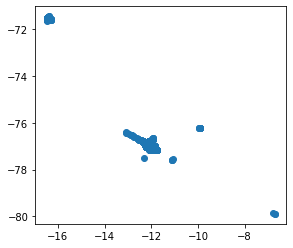

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/drivers_point.csv')
print(df.shape) # nb line/col

df['geometry'] = df['geometry'].apply(wkt.loads)
df = df.drop('Unnamed: 0', axis = 1)
gdf_points = gpd.GeoDataFrame(df).set_geometry('geometry')

plot = gdf_points.plot()
display(plot)

(51, 3)


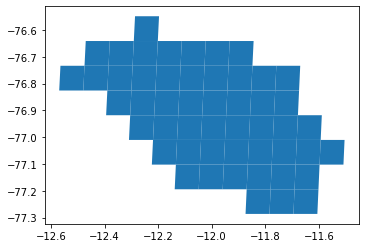

In [8]:
df = pd.read_csv('/content/drive/MyDrive/zones_poly.csv')
print(df.shape) # nb line/col

df['geometry'] = df['geometry'].apply(wkt.loads)
gdf_zones = gpd.GeoDataFrame(df).set_geometry('geometry')

plot = gdf_zones.plot()
display(plot)

In [9]:
drivers = spark.read.csv('/content/drive/MyDrive/drivers.csv', header=True, inferSchema=True)
# print(drivers.count()) # nb line

# drivers.show()

In [10]:
def find_intersection(longitude, latitude): 
    mgdf = gdf_zones.apply(lambda x: x['id_zone'] if x['geometry'].intersects(Point(latitude, longitude)) else None, axis=1)
    idx = mgdf.first_valid_index()
    first_valid_value = mgdf.loc[idx] if idx is not None else 0
    return int(first_valid_value)

find_intersection_udf = udf(find_intersection, IntegerType())

In [11]:
drivers = drivers.withColumn("id_zone", find_intersection_udf(col("longitude"), col("latitude")))
# print(drivers.count()) # nb line

# drivers.show() 
# drivers.toPandas().to_csv('drivers_with_zones.csv')

In [ ]:
drivers.groupby('id_zone').count().sort(col('count').desc()).show()

# Question 2

In [17]:
from pyspark.sql.functions import lag, col
from pyspark.sql.window import Window

w = Window().partitionBy().orderBy(["driver","timestamp"])
drivers = drivers.withColumn("previous_timestamp", lag("timestamp", 1, None).over(w))
drivers = drivers.withColumn("previous_latitude", lag("latitude", 1, 0).over(w))
drivers = drivers.withColumn("previous_longitude", lag("longitude", 1, 0).over(w))

drivers = drivers.na.drop() # Drop na (eg first row of each driver_id)

In [18]:
import geopy.distance

# From Haversine formula : https://en.wikipedia.org/wiki/Haversine_formula
'''
Results nearly the same :
For instance :  
   - geopy.distance.distance((-12.024073, -77.008618),(-12.025772,-77.015158)).km = 737 m
   - With Haversine formula = 736 m

Or :
   - geopy.distance.distance((-12.012207, -77.002409), (-12.024073, -77.008618)).km = 1.477 km
   - With Haversine formula = 1.482 km
'''

drivers = drivers.withColumn("computation_for_distances", 
                   pow(sin(toRadians(drivers.latitude - drivers.previous_latitude) / 2), 2) + cos(toRadians(drivers.previous_latitude)) * cos(toRadians(drivers.latitude)) * pow(sin(toRadians(drivers.longitude - drivers.previous_longitude) / 2), 2)
                   )

# Calculate the distance
drivers = drivers.withColumn("distance_km_from_previous", 
                             atan2(sqrt(drivers.computation_for_distances), sqrt(-drivers.computation_for_distances + 1)) * 2 * 6371
                             )

In [19]:
# Calculate the duration
drivers = drivers.withColumn("duration_hour_from_previous", 
                            (col("timestamp").cast("long") - col("previous_timestamp").cast("long"))/3600
                            )
# Calculate the speed
drivers = drivers.withColumn("speed_km_h_from_previous", 
                   drivers.distance_km_from_previous/ drivers.duration_hour_from_previous
                  )



# Speed grouped by driver_id

In [ ]:
# Calculate the speed of each driver
drivers_id_groupby = drivers.groupby('driver').agg(sum('distance_km_from_previous').alias('sum_distance_km'), \
                                                     min("timestamp").alias("start_timestamp"), \
                                                     max("timestamp").alias("end_timestamp"))
drivers_id_groupby.show()

+--------+------------------+-------------------+-------------------+
|  driver|   sum_distance_km|    start_timestamp|      end_timestamp|
+--------+------------------+-------------------+-------------------+
|000aa4d2|30.818162326734562|2017-08-31 14:51:01|2017-08-31 16:59:53|
|001b6172|30.311152421081214|2017-08-31 15:32:06|2017-08-31 16:59:41|
|00219be2|30.153481360627787|2017-08-31 16:21:42|2017-08-31 16:59:54|
|0022cc1b|26.416079078646394|2017-08-31 16:23:46|2017-08-31 16:51:00|
|0022f5ae|47.830053033597146|2017-08-31 12:00:16|2017-08-31 16:59:39|
|0024001c| 59.70517202348222|2017-08-31 12:56:44|2017-08-31 16:47:22|
|002b543c|15.026920602146275|2017-08-31 15:37:39|2017-08-31 16:22:34|
|00306389| 50.12580163420855|2017-08-31 15:22:19|2017-08-31 16:59:55|
|0032c785| 38.95141438152853|2017-08-31 13:55:52|2017-08-31 16:59:56|
|003767cc| 25.35680900594882|2017-08-31 15:38:26|2017-08-31 16:59:50|
|0037c705|58.854145952943846|2017-08-31 12:03:37|2017-08-31 16:59:41|
|0038cfc9|12.8989624

In [ ]:
drivers_id_groupby = drivers_id_groupby.withColumn("duration_hour", 
                                            (col("end_timestamp").cast("long") - col("start_timestamp").cast("long"))/3600
                                            )

drivers_id_groupby = drivers_id_groupby.withColumn("speed", 
                                            drivers_id_groupby.sum_distance_km/drivers_id_groupby.duration_hour
                                            )
drivers_id_groupby.select(['driver', 'speed']).show()

+--------+------------------+
|  driver|             speed|
+--------+------------------+
|000aa4d2|14.348859852075067|
|001b6172|20.765014027762582|
|00219be2| 47.36148904810647|
|0022cc1b| 58.19943983055509|
|0022f5ae|  9.58571457556921|
|0024001c|15.532491637847665|
|002b543c|20.073066481531203|
|00306389| 30.81504198824296|
|0032c785|12.696947824475073|
|003767cc|18.690522608807484|
|0037c705|11.927208141781009|
|0038cfc9|1547.8754903442327|
|003ae775| 29.33175158991654|
|003e4814|  9.49104823232186|
|003ee476|10.879680400063357|
|003fa137| 18.08966366768218|
|004325cc| 19.73278818712167|
|004655be|15.052401325574515|
|004721ca|16.625119605230395|
|004725b8| 22.26462384727454|
+--------+------------------+
only showing top 20 rows



In [ ]:
# Saving
# drivers_id_groupby.toPandas().to_csv('drivers_id_groupby.csv')

In [ ]:
driver_df = pd.read_csv('/content/drive/MyDrive/drivers_id_groupby.csv')
driver_df

,Unnamed: 0,driver,sum_distance_km,start_timestamp,end_timestamp,duration_hour,speed
0,0,000aa4d2,30.887439,2017-08-31 14:50:49,2017-08-31 16:59:53,2.151111,14.358830
1,1,001b6172,30.311152,2017-08-31 15:32:06,2017-08-31 16:59:41,1.459722,20.765014
2,2,00219be2,30.153481,2017-08-31 16:21:42,2017-08-31 16:59:54,0.636667,47.361489
3,3,0022cc1b,26.416079,2017-08-31 16:23:46,2017-08-31 16:51:00,0.453889,58.199440
4,4,0022f5ae,47.830053,2017-08-31 12:00:16,2017-08-31 16:59:39,4.989722,9.585715
...,...,...,...,...,...,...,...
14647,14647,f7dbb0f4,52.810802,2017-08-31 12:14:51,2017-08-31 16:59:49,4.749444,11.119364
14648,14648,f91369ba,11.129814,2017-08-31 12:02:38,2017-08-31 13:33:27,1.513611,7.353153
14649,14649,fa2ea060,53.975809,2017-08-31 12:33:12,2017-08-31 16:01:45,3.475833,15.528883
14650,14650,fad5e2f5,22.710066,2017-08-31 14:08:36,2017-08-31 14:21:31,0.215278,105.491918


In [ ]:
import plotly.express as px
fig = px.box(driver_df, y="speed")
fig.show()

# Speed grouped by zone_id

In [20]:
# Calculate the speed from each zone

zone_id_groupby = drivers.groupby('id_zone').agg(sum('distance_km_from_previous').alias('sum_distance_km'), \
                                                 sum("duration_hour_from_previous").alias("sum_duration_hour"))
zone_id_groupby = zone_id_groupby.withColumn("speed", 
                                            zone_id_groupby.sum_distance_km/zone_id_groupby.sum_duration_hour
                                            )
zone_id_groupby.show()

'''
We were not able to show the results of the groupBy function.
For an unknown reason, the method show() took too long and runned indefinitely 
'''

KeyboardInterrupt: ignored

# Cleaning up

It is **vital** that you stop your spark instance after you are done working with it, **especially when running in cluster mode**. If you do not do this, the resources acquired by your spark instance (i.e., the number of cores and memory reserved for it) will be kept indefinetely, and *are hence not available for others!*

In [21]:
sc.stop()